# 1. Introduction
This notebook is part of a machine learning for healthcare exercise, focusing on using the Responsible AI (RAI) package to enhance clinical decision-making. The toolkit will be used to analyze opioid use disorder (OD) risk, with three key objectives:

1. Analyze Errors and Explore Interpretability of Models: We will run Interpret-Community’s global explainers to generate feature importance insights and visualize model errors with the Error Analysis dashboard

2. Plan real-world action through counterfactual and causal analysis: By leveraging counterfactual examples and causal inference, we will explore decision-making strategies based on opioid prescription patterns and patient comorbidities to understand possible interventions and their impacts

3. Assess addiction risk predictions: A classification model trained on patient-level features (income, surgeries, opioid prescription days, and comorbidities A–V) will be evaluated to examine its performance in predicting risk of opioid use disorder and to inform prevention strategies

**The goal is to provide non-trivial insights for clinical decision making, leveraging machine learning paired with responsible AI tools, to improve patient outcomes in the healthcare context.**

Based on notebooks from the [Responsible AI toolkit](https://github.com/microsoft/responsible-ai-toolbox/tree/main/notebooks)


# 2. Data Set Characteristics

Number of Instances: patient-level records (rows)

Number of Attributes: 20 predictive attributes and 1 target class

Attribute Information:
- OD (target): whether the patient had an opioid use disorder diagnosis (binary: 1 = yes, 0 = no)
- Low_inc: low income flag (1 = low income, 0 = not low income)
- Surgery: whether the patient underwent major surgery in the 2 years
- rx_ds: number of days of prescribed opioids in the 2 years
- A: infectious diseases group A (binary flag)
- B: infectious diseases group B
- C: malignant neoplasm
- D: benign neoplasm
- E: endocrine conditions
- F: mental and behavioral health conditions (excluding opioid-related)
- H: ear conditions
- I: circulatory system conditions
- J: respiratory system conditions
- K: digestive system conditions
- L: skin conditions
- M: musculoskeletal system conditions
- N: urinary system conditions
- R: other signs and symptoms
- S: injuries
- T: burns and toxic conditions
- V: external trauma conditions

class:
- OD = 1: patient identified with opioid use disorder in the 2 years
- OD = 0: patient without opioid use disorder


# 3. Setup
- responsibleai and raiwidgets provide RAIInsights and the dashboard
- fairlearn provides fairness metrics and mitigation algorithms used under the hood
- imbalanced-learn offers resampling utilities if you want to experiment with imbalance mitigation

In [34]:
# 1. Setup

from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, kendalltau
from IPython.display import display, Markdown

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.feature_selection import VarianceThreshold
from sklearn.base import clone
from sklearn.metrics import (
    roc_auc_score,           # Measures the ability of the model to distinguish between classes (higher is better)
    average_precision_score, # Computes the average precision for precision-recall curves (useful for imbalanced data)
    brier_score_loss,        # Measures the mean squared difference between predicted probabilities and actual outcomes (lower is better)
    log_loss,                # Penalizes false classifications with a focus on probability estimates (lower is better)
    confusion_matrix,        # Summarizes true/false positives/negatives for classification predictions
    precision_score,         # Proportion of positive identifications that were actually correct (TP / (TP + FP))
    recall_score,            # Proportion of actual positives that were correctly identified (TP / (TP + FN))
    RocCurveDisplay,         
    PrecisionRecallDisplay,
    f1_score,
)

# Fairness utilities
try:
    from fairlearn.metrics import (
        MetricFrame,
        selection_rate,
        true_positive_rate,
        false_positive_rate,
    )
    _FAIRLEARN = True
except Exception:
    _FAIRLEARN = False

# Responsible AI dashboard
try:
    from responsibleai import RAIInsights
    from responsibleai.feature_metadata import FeatureMetadata
    from raiwidgets import ResponsibleAIDashboard, ExplanationDashboard
    from interpret_community.tabular_explainer import TabularExplainer
    from fairlearn.metrics import (
        MetricFrame,
        selection_rate,
        true_positive_rate,
        false_positive_rate,
        false_negative_rate,
    )
    _RAI = True
except Exception:
    _RAI = False

# Course utilities for transparency and thresholding
from utils import (
    positive_scores,
    auc_report,
    tradeoff_table,
    pick_threshold_cost,
    pick_threshold_recall_floor,
    pick_threshold_workload,
    summary_at_threshold,
    plot_recall_floor_curves,
    plot_cumulative_recall_at_threshold,
    plot_topk_at_threshold,
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


# 4. Data Load & preparation

In [4]:
# Path to your CSV (update if needed for your system)
DATA_PATH = "./Data/opiod_raw_data.csv"

df_raw = pd.read_csv(DATA_PATH)
print("Shape:", df_raw.shape)
df_raw.head()

Shape: (1000, 22)


,ID,OD,Low_inc,SURG,rx ds,A,B,C,D,E,...,I,J,K,L,M,N,R,S,T,V
0,1,1,1,0,516,0,0,0,1,0,...,1,0,1,1,1,0,1,0,0,0
1,2,1,1,0,119,0,0,1,0,0,...,1,1,0,0,1,1,1,1,0,0
2,3,1,1,1,925,1,1,0,1,1,...,1,0,0,0,1,0,1,0,1,0
3,4,0,1,0,393,1,1,0,0,0,...,0,0,1,1,1,0,1,1,1,0
4,5,1,1,0,630,0,0,0,0,1,...,0,0,0,0,1,1,1,0,0,0


In [5]:
# Outcome prevalence and missingness

TARGET = "OD"  # target: 1 = opioid use disorder diagnosis, 0 = none

# Outcome prevalence
counts = df_raw[TARGET].value_counts(dropna=False)
prevalence_percent = counts[1] / counts.sum() * 100
positives_per_1000 = counts[1] / counts.sum() * 1000

print("Outcome counts:")
print(counts)
print(f"\nPrevalence: {prevalence_percent:.2f}%")
print(f"Patients with OD per 1000: {positives_per_1000:.1f}")

Outcome counts:
0    819
1    181
Name: OD, dtype: int64

Prevalence: 18.10%
Patients with OD per 1000: 181.0


## 4.1. Basic cleaning and schema alignment

In [6]:
# Create a copy of the raw DataFrame
df = df_raw.copy()

# Standardize column names
df.columns = [c.strip().replace(" ", "_").replace("-", "_")
              for c in df.columns]

# Drop ID column
if df.shape[1] > 0:
    df = df.drop(columns=[df.columns[0]])

# Harmonize known aliases
if "SURG" in df.columns and "Surgery" not in df.columns:
    df = df.rename(columns={"SURG": "Surgery"})

# Expected columns from the data dictionary
expected_cols = [
    "OD", "Low_inc", "Surgery", "rx_ds",
    "A", "B", "C", "D", "E", "F", "H", "I", "J", "K", "L", "M", "N", "R", "S", "T", "V"
]

missing = [c for c in expected_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing expected columns: {missing}")

# Helper to coerce various binary encodings to 0/1


def to_binary(s: pd.Series) -> pd.Series:
    if s.dtype == "O":
        mapped = s.astype(str).str.strip().str.lower().map({
            "1": 1, "0": 0,
            "y": 1, "n": 0,
            "yes": 1, "no": 0,
            "true": 1, "false": 0
        })
        s = pd.to_numeric(mapped, errors="coerce")
    else:
        s = pd.to_numeric(s, errors="coerce")
    return (s.fillna(0) > 0).astype(int)


# Target is binary 0/1
df["OD"] = to_binary(df["OD"])

# rx_ds is numeric count of opioid prescription days
df["rx_ds"] = pd.to_numeric(df["rx_ds"], errors="coerce")

# Binary predictors: Low_inc, Surgery, and A..V
binary_cols = ["Low_inc", "Surgery", "A", "B", "C", "D", "E",
               "F", "H", "I", "J", "K", "L", "M", "N", "R", "S", "T", "V"]
df[binary_cols] = df[binary_cols].apply(to_binary)

df.head()

,OD,Low_inc,Surgery,rx_ds,A,B,C,D,E,F,...,I,J,K,L,M,N,R,S,T,V
0,1,1,0,516,0,0,0,1,0,1,...,1,0,1,1,1,0,1,0,0,0
1,1,1,0,119,0,0,1,0,0,1,...,1,1,0,0,1,1,1,1,0,0
2,1,1,1,925,1,1,0,1,1,0,...,1,0,0,0,1,0,1,0,1,0
3,0,1,0,393,1,1,0,0,0,1,...,0,0,1,1,1,0,1,1,1,0
4,1,1,0,630,0,0,0,0,1,1,...,0,0,0,0,1,1,1,0,0,0


# 5. Training, Validation and Testing - 80/15/5 stratified split

Train–test split

- Prevents “peeking” at data and overestimating performance
- Mimics real-world deployment where models face unseen patients
- Always evaluate on data not used for training

In [7]:
target_col = "OD"
num_cols = ["rx_ds"]
cat_like_binary_cols = binary_cols.copy()

X = df[num_cols + cat_like_binary_cols].copy()
y = df[target_col].copy()

# 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Split temp into validation and test, 15% each overall
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.25, stratify=y_temp, random_state=RANDOM_STATE
)
# Display shapes and class distributions as a DataFrame

info = {
    "Set": ["Train", "Validation", "Test", "Overall"],
    "X shape": [X_train.shape, X_val.shape, X_test.shape, X.shape],
    "y shape": [y_train.shape, y_val.shape, y_test.shape, y.shape],
    "p(OD=0)": [
        y_train.value_counts(normalize=True).get(0, 0.0),
        y_val.value_counts(normalize=True).get(0, 0.0),
        y_test.value_counts(normalize=True).get(0, 0.0),
        y.value_counts(normalize=True).get(0, 0.0),
    ],
    "p(OD=1)": [
        y_train.value_counts(normalize=True).get(1, 0.0),
        y_val.value_counts(normalize=True).get(1, 0.0),
        y_test.value_counts(normalize=True).get(1, 0.0),
        y.value_counts(normalize=True).get(1, 0.0),
    ],
}

df_info = pd.DataFrame(info)
display(df_info.style.format({"p(OD=0)": "{:.3f}", "p(OD=1)": "{:.3f}"}))

,Set,X shape,y shape,p(OD=0),p(OD=1)
0,Train,"(800, 20)","(800,)",0.819,0.181
1,Validation,"(150, 20)","(150,)",0.820,0.180
2,Test,"(50, 20)","(50,)",0.820,0.180
3,Overall,"(1000, 20)","(1000,)",0.819,0.181


## 5.1. Modeling pipeline, training, and calibration

### Setting a baseline
A naive majority-class baseline clarifies the minimum standard any model must beat, highlighting the danger of ignoring minority patients and ensuring improvements carry meaningful weight in healthcare decision making

**ROC AUC**  
- 0.5 → no discrimination
- 0.6–0.7 → poor
- 0.7–0.8 → fair
- 0.8–0.9 → good
- ≥ 0.9 → excellent

**PR AUC**  
- Must be interpreted against event prevalence `p` in the validation set  

Dummy baseline
PR AUC: 0.180
ROC AUC: 0.500
Prevalence p = 0.180  |  PR AUC lift = 1.00× over baseline


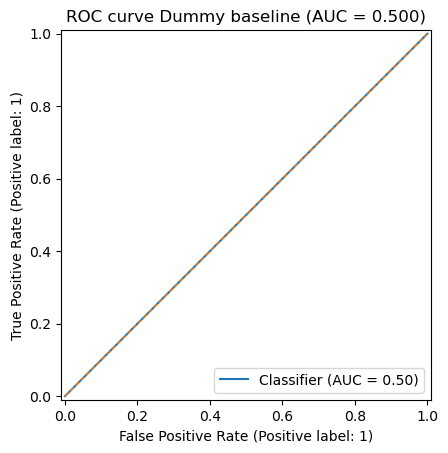

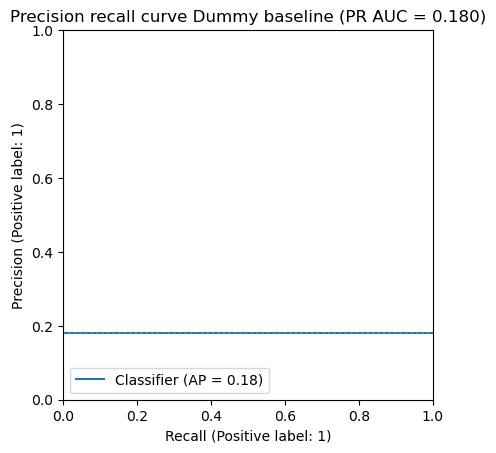

In [8]:
# Baseline: DummyClassifier (majority class)
dummy_clf = DummyClassifier(
    strategy="most_frequent", random_state=RANDOM_STATE)
dummy_clf.fit(X_train, y_train)

proba_val = dummy_clf.predict_proba(X_val)
pos_idx = int(np.where(dummy_clf.classes_ == 1)[0][0])  # index for class "1"
y_score_val = np.asarray(proba_val)[:, pos_idx]

# Evaluate on validation
y_score_val = positive_scores(dummy_clf, X_val)
metrics_dummy = auc_report(
    y_val, y_score_val, name="Dummy baseline", plot=True)

## 5.2. Preprocesing our Pipeline

[Scikit-learn preprocessing](https://scikit-learn.org/stable/api/sklearn.preprocessing.html) standardizes and transforms features for modeling, including scaling, encoding, and imputation. Helping to maintain a consistent data transformation workflow

In [9]:
# Preprocessing
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True))
])

binary_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("bin", binary_transformer, cat_like_binary_cols)
    ],
    remainder="drop",  # drops any column not in previously specified
    verbose_feature_names_out=False  # keeps original feature names
)

# Logistic Regression baseline with variance filter
base_clf = Pipeline(steps=[
    ("prep", preprocess),
    # Eliminates features with zero variance
    ("varth", VarianceThreshold(threshold=0.0)),
    ("model", LogisticRegression(
        solver="liblinear",  # See details in course material
        class_weight="balanced",  # Adjusts weights for class imbalance
        random_state=RANDOM_STATE,
        max_iter=200
    ))
])

### Basic preliminary model performance check

base_clf
PR AUC: 0.495
ROC AUC: 0.750
Prevalence p = 0.180  |  PR AUC lift = 2.75× over baseline


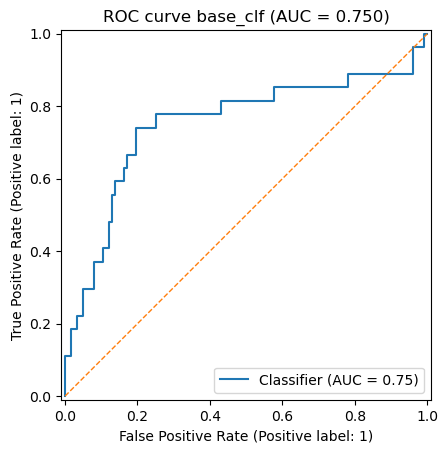

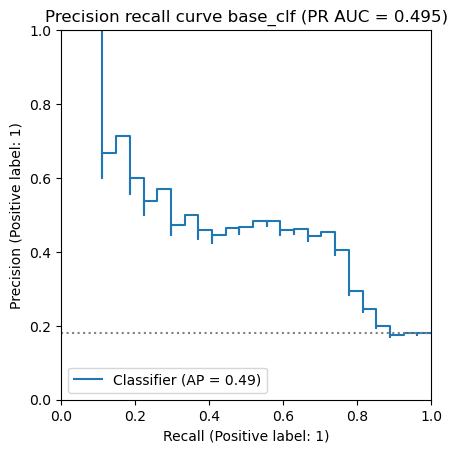

In [10]:
# Fit base model
base_clf.fit(X_train, y_train)

# Evaluate on validation
y_score_val = positive_scores(base_clf, X_val)
metrics_base = auc_report(y_val, y_score_val, name="base_clf", plot=True)

In [11]:
# Five patients: raw pre-calibration score, predicted label, actual label

tbl5 = (
    pd.DataFrame(
        {
            "raw_score": positive_scores(base_clf, X_val),
            "actual": y_val.loc[X_val.index].astype(int),
        },
        index=X_val.index,
    )
    .assign(predicted=lambda d: (d["raw_score"] >= 0.50).astype(int))  # threshold before calibration
    .round({"raw_score": 3})
    .sample(n=10, random_state=7)
    .reset_index()
    .rename(columns={"index": "patient"})
    .loc[:, ["patient", "raw_score", "predicted", "actual"]]
)

display(tbl5)


,patient,raw_score,predicted,actual
0,641,0.274,0,0
1,466,0.799,1,1
2,993,0.415,0,0
3,860,0.278,0,0
4,486,0.211,0,0
5,305,0.560,1,0
6,166,0.270,0,0
7,24,0.636,1,0
8,602,0.396,0,0
9,573,0.326,0,0


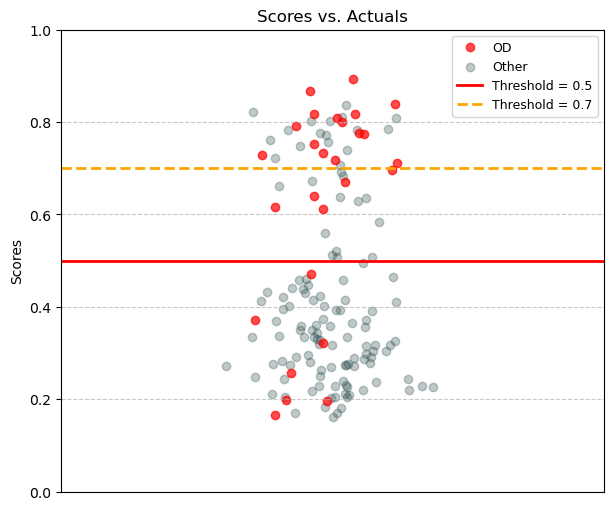

In [12]:
# Data for the plot using variables from the preceding cells
scores = positive_scores(base_clf, X_val)
actuals = y_val

# Separate scores for actual positive (OD=1) and negative (OD=0) cases
scores_positive = scores[actuals == 1]
scores_negative = scores[actuals == 0]

# Generate random jitter for the x-axis
jitter_strength = 0.03
jitter_positive = np.random.normal(0, jitter_strength, len(scores_positive))
jitter_negative = np.random.normal(0, jitter_strength, len(scores_negative))

# 3. Create the plot
fig, ax = plt.subplots(figsize=(7, 6))
scatter_other = ax.scatter(jitter_negative, scores_negative, color='darkslategrey', alpha=0.3, label='Other')
scatter_target = ax.scatter(jitter_positive, scores_positive, color='red', alpha=0.7, label='OD')

# Add threshold lines
line_50 = ax.axhline(y=0.5, color='red', linestyle='-', linewidth=2, label='Threshold = 0.5')
line_80 = ax.axhline(y=0.7, color='orange', linestyle='--', linewidth=2, label='Threshold = 0.7')

ax.set_title('Scores vs. Actuals')
ax.set_ylabel('Scores')
ax.set_ylim(0, 1)
ax.set_xticks([])
ax.set_xlim(-0.2, 0.2) # Set fixed x-axis limits to control the visual spread
ax.legend(handles=[scatter_target, scatter_other, line_50, line_80], fontsize=9, loc='upper right')

ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 6. Recalibrating the Scores

**1. Reliable probabilities**  
- Turns raw scores into real probabilities  
- Ensures predictions match observed outcome frequencies  
- Prevents overly high or low risk estimates  

**2. Better clinical decisions**  
- Essential when risk values guide medical choices  
- Supports thresholds with clear clinical meaning
- Reduces wasted clinical resources  

**3. Trust and adoption**  
- Builds trust in AI decisions  
- Enables safer patient outcomes

In [13]:
# Calibrate probabilities using CV on training data
calibrated_clf = CalibratedClassifierCV(
    estimator=base_clf,
    method="sigmoid",
    cv=5
)
calibrated_clf.fit(X_train, y_train)

CalibratedClassifierCV(cv=5,
                       estimator=Pipeline(steps=[('prep',
                                                  ColumnTransformer(transformers=[('num',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    SimpleImputer(strategy='median')),
                                                                                                   ('scaler',
                                                                                                    StandardScaler())]),
                                                                                   ['rx_ds']),
                                                                                  ('bin',
                                                                                   Pipeline(steps=[('imputer',
                                                                                                    SimpleImputer(strategy='most_frequent'))]),
                                                                                   ['Low_inc',
                                                                                    'Surgery',
                                                                                    'A',
                                                                                    'B',
                                                                                    'C',
                                                                                    'D',
                                                                                    'E',
                                                                                    'F',
                                                                                    'H',
                                                                                    'I',
                                                                                    'J',
                                                                                    'K',
                                                                                    'L',
                                                                                    'M',
                                                                                    'N',
                                                                                    'R',
                                                                                    'S',
                                                                                    'T',
                                                                                    'V'])],
                                                                    verbose_feature_names_out=False)),
                                                 ('varth', VarianceThreshold()),
                                                 ('model',
                                                  LogisticRegression(class_weight='balanced',
                                                                     max_iter=200,
                                                                     random_state=42,
                                                                     solver='liblinear'))]))

,Risk_band,Patients,Avg_pred_before,Actual_OD_rate,Avg_pred_after
0,Q1,5,0.219,0.0,0.082
1,Q2,5,0.256,0.2,0.094
2,Q3,5,0.313,0.0,0.113
3,Q4,5,0.331,0.0,0.119
4,Q5,5,0.391,0.0,0.141
5,Q6,5,0.482,0.2,0.178
6,Q7,5,0.633,0.4,0.260
7,Q8,5,0.691,0.2,0.300
8,Q9,5,0.744,0.2,0.341
9,Q10,5,0.800,0.6,0.399


Check sizes
len(X_train) = 800 len(X_val) = 150 len(X_test) = 50
Rows in table sum to 50
Points near the diagonal mean predicted risk matches observed OD frequency


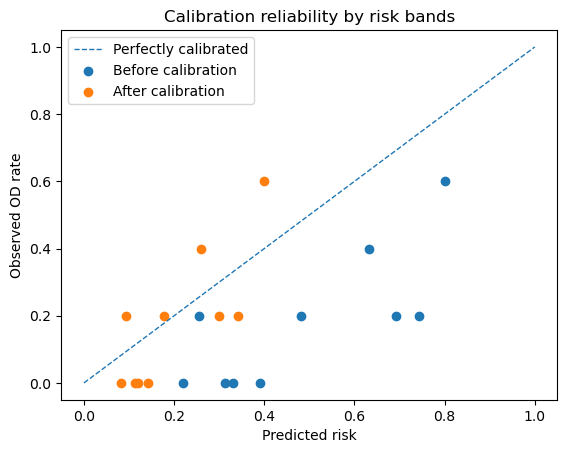

In [14]:
# Quantile bands on test only
base_clf_uncal = clone(base_clf).fit(X_train, y_train)
p_before = base_clf_uncal.predict_proba(X_test)[:, 1]
p_after = calibrated_clf.predict_proba(X_test)[:, 1]

df_cal = pd.DataFrame({"Actual_OD": y_test.values, "Pred_before": p_before,
                      "Pred_after": p_after}, index=X_test.index)

# 10 quantile bands with similar counts
df_cal["Risk_band"] = pd.qcut(df_cal["Pred_after"], q=10, labels=[
                              f"Q{i}" for i in range(1, 11)], duplicates="drop")

summary = (
    df_cal.groupby("Risk_band", observed=True)
    .agg(Patients=("Actual_OD", "size"),
         Avg_pred_before=("Pred_before", "mean"),
         Actual_OD_rate=("Actual_OD", "mean"),
         Avg_pred_after=("Pred_after", "mean"))
    .reset_index()
    .round(3)
)
display(summary)

print("Check sizes")
print("len(X_train) =", len(X_train), "len(X_val) =",
      len(X_val), "len(X_test) =", len(X_test))
print("Rows in table sum to", int(summary["Patients"].sum()))

# Reliability plot using the same fixed risk bands summary
print("Points near the diagonal mean predicted risk matches observed OD frequency")
plt.figure()
plt.plot([0, 1], [0, 1], linestyle="--",
         linewidth=1, label="Perfectly calibrated")
plt.scatter(summary["Avg_pred_before"],
            summary["Actual_OD_rate"], label="Before calibration")
plt.scatter(summary["Avg_pred_after"],
            summary["Actual_OD_rate"],  label="After calibration")
plt.xlabel("Predicted risk")
plt.ylabel("Observed OD rate")
plt.title("Calibration reliability by risk bands")
plt.legend()
plt.show()

### Compare base_clf vs calibrated_clf on validation

In [15]:
# Focus on discrimination equality and calibration improvements

# Scores
y_score_val_base = positive_scores(base_clf, X_val)
y_score_val_cal = positive_scores(calibrated_clf, X_val)

# Discrimination
roc_base = roc_auc_score(y_val, y_score_val_base)
pr_base = average_precision_score(y_val, y_score_val_base)
roc_cal = roc_auc_score(y_val, y_score_val_cal)
pr_cal = average_precision_score(y_val, y_score_val_cal)

# Calibration
ll_base = log_loss(y_val, np.clip(y_score_val_base, 1e-6, 1 - 1e-6))
ll_cal = log_loss(y_val, np.clip(y_score_val_cal,  1e-6, 1 - 1e-6))
brier_base = brier_score_loss(y_val, y_score_val_base)
brier_cal = brier_score_loss(y_val, y_score_val_cal)

# Assemble into dataframe
metrics_df = pd.DataFrame([
    {"Metric": "ROC AUC", "Base": roc_base, "Calibrated": roc_cal, "Explanation": "Ability to distinguish between classes (higher is better)"},
    {"Metric": "PR AUC", "Base": pr_base, "Calibrated": pr_cal, "Explanation": "Precision-recall curve area; useful for imbalanced data"},
    {"Metric": "Log loss", "Base": ll_base, "Calibrated": ll_cal, "Explanation": "Penalty for incorrect and overconfident predictions (lower is better)"},
    {"Metric": "Brier score", "Base": brier_base, "Calibrated": brier_cal, "Explanation": "Mean squared error of predicted probabilities (lower is better)"},
])

display(metrics_df.style.format({"Base": "{:.3f}", "Calibrated": "{:.3f}"}))

,Metric,Base,Calibrated,Explanation
0,ROC AUC,0.750,0.750,Ability to distinguish between classes (higher is better)
1,PR AUC,0.495,0.497,Precision-recall curve area; useful for imbalanced data
2,Log loss,0.589,0.400,Penalty for incorrect and overconfident predictions (lower is better)
3,Brier score,0.198,0.123,Mean squared error of predicted probabilities (lower is better)


# 7. Deciding where to cut off i.e. what probability is “high risk enough” to trigger an intervention?

,precision,recall,alerts_per_1000,true_pos_per_1000,FP,FN
threshold,,,,,,
0.1,0.204,0.852,753.333,153.333,90,4
0.2,0.435,0.741,306.667,133.333,26,7
0.3,0.485,0.593,220.000,106.667,17,11
0.4,0.600,0.222,66.667,40.000,4,21
0.5,1.000,0.037,6.667,6.667,0,26


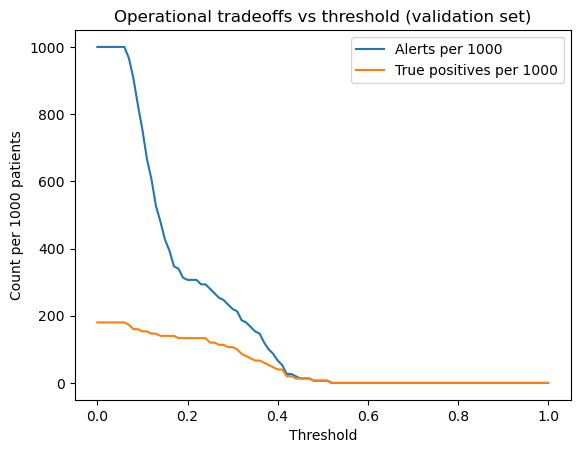

In [16]:
# Get calibrated probabilities
y_score_val = positive_scores(calibrated_clf, X_val)

# Define a grid of thresholds
thresholds = np.linspace(0, 1, 101)
rows = []
for thr in thresholds:
    y_pred = (y_score_val >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    alerts_per_1000 = 1000 * np.mean(y_pred)
    true_pos_per_1000 = 1000 * tp / len(y_val)
    rows.append({
        "threshold": thr,
        "precision": precision,
        "recall": recall,
        "alerts_per_1000": alerts_per_1000,
        "true_pos_per_1000": true_pos_per_1000,
        "FP": fp,
        "FN": fn
    })

df_thr = pd.DataFrame(rows)

# Display a few candidate thresholds for discussion
display(
    df_thr.query("threshold in [0.1, 0.2, 0.3, 0.4, 0.5]")
         .round(3)
         .set_index("threshold")
)

# Plot workload vs threshold
plt.figure()
plt.plot(df_thr["threshold"], df_thr["alerts_per_1000"], label="Alerts per 1000")
plt.plot(df_thr["threshold"], df_thr["true_pos_per_1000"], label="True positives per 1000")
plt.xlabel("Threshold")
plt.ylabel("Count per 1000 patients")
plt.title("Operational tradeoffs vs threshold (validation set)")
plt.legend()
plt.show()

## 7.1. Choosing an operating threshold

Models produce probabilities, but clinicians are the ones taking decisions, and carring the accountability of their actions.

- Setting a threshold balances in this case, among others, between missed addiction cases and unnecessary undertreatment of pain
- Clear rules make these tradeoffs explicit, explainable, and auditable!

We will run three threshold tuning analyses:
1. **Workload constrained threshold**  
  Capture the most true cases without exceeding a fixed alert capacity for the clinic
2. **Recall floor then maximize precision**  
  Guarantee a minimum case capture for safety, then pick the threshold with the fewest false alarms
3. **Cost based threshold (Bayes rule)**  
  Minimize expected harm using estimated costs for false negatives and false positives

Readouts to watch
- Threshold, precision, recall, alerts per 1000 patients, true positives per 1000, false positives, false negatives
- Connect the chosen rule to clinical policy and resource capacity

### 7.1.1. Workload constrained threshold for calibrated_clf on validation

- Alerts budget: maximum alerts per 1000 patients the clinic can review without overloading resources
- Objective: within the alerts budget, choose the threshold that yields the most true positives per 1000 so more patients at real risk are correctly flagged

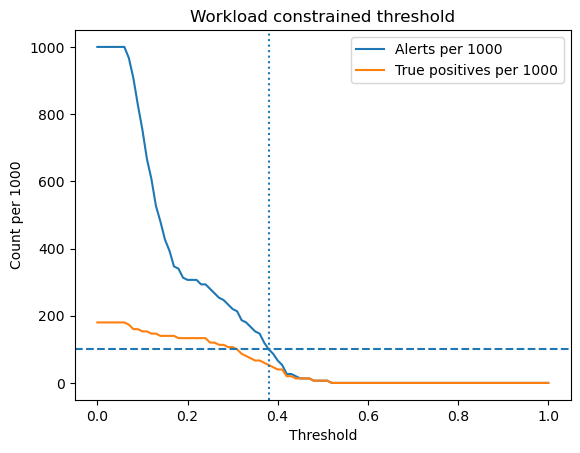

rule,Max TP per 1000 under budget
metric,
threshold,0.380
precision,0.533
recall,0.296
TP,8.000
FP,7.000
TN,116.000
FN,19.000
alerts_per_1000,100.000
true_pos_per_1000,53.333


In [17]:
ALERTS_BUDGET = 100.0  # alerts per 1000 patients

y_score_val = positive_scores(calibrated_clf, X_val)
res = pick_threshold_workload(y_val, y_score_val, alerts_per_1000_max=ALERTS_BUDGET)
tbl = res["table"]

plt.figure()
plt.plot(tbl["threshold"], tbl["alerts_per_1000"], label="Alerts per 1000")
plt.plot(tbl["threshold"], tbl["true_pos_per_1000"], label="True positives per 1000")
plt.axhline(ALERTS_BUDGET, linestyle="--")
plt.axvline(res["threshold"], linestyle=":")
plt.xlabel("Threshold")
plt.ylabel("Count per 1000")
plt.title("Workload constrained threshold")
plt.legend()
plt.show()

# make sure summary_df is a DataFrame
summary_df = res["summary"] if isinstance(res["summary"], pd.DataFrame) else pd.DataFrame(res["summary"])

# put metrics in the rows, rules in the columns
pivot_df = summary_df.set_index("rule").T.reset_index().rename(columns={"index": "metric"})
display(pivot_df.round(3).set_index("metric"))


Let's now see the risk groups by decile (bands), and visualizes the overall risk score distribution, with optional threshold overlay and decile boundaries

,n,positives,min_score,max_score,prevalence,cum_capture,alerts_per_1000,true_pos_per_1000
band,,,,,,,,
1,15,8,0.381,0.520,0.533,0.296,100.0,53.333
2,15,5,0.316,0.378,0.333,0.481,100.0,33.333
3,15,7,0.229,0.316,0.467,0.741,100.0,46.667
4,15,1,0.159,0.221,0.067,0.778,100.0,6.667
5,15,1,0.135,0.156,0.067,0.815,100.0,6.667
6,15,0,0.121,0.134,0.000,0.815,100.0,0.000
7,15,1,0.106,0.120,0.067,0.852,100.0,6.667
8,15,1,0.097,0.105,0.067,0.889,100.0,6.667
9,15,0,0.083,0.093,0.000,0.889,100.0,0.000


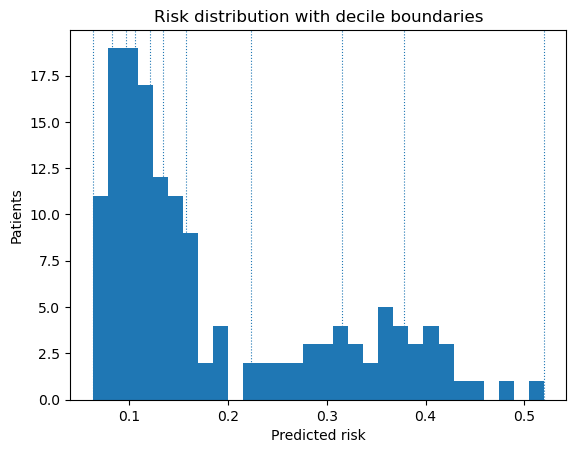

In [18]:
N_BINS = 10  # deciles by default
y_score_val = positive_scores(calibrated_clf, X_val)

# Build bands by quantiles, highest risk = band 1
bands = pd.qcut(y_score_val, q=N_BINS, labels=False, duplicates="drop")
# qcut labels lowest=0..highest=K-1, invert so 1 is highest-risk band
bands = (bands.max() - bands) + 1

df = pd.DataFrame({
    "y_true": y_val.astype(int),
    "score": y_score_val,
    "band": bands.astype(int),
})

summ = (df.groupby("band", as_index=True)
          .agg(n=("y_true","size"),
               positives=("y_true","sum"),
               min_score=("score","min"),
               max_score=("score","max"))
          .sort_index())

summ["prevalence"] = summ["positives"] / summ["n"]
summ["cum_capture"] = summ["positives"].cumsum() / df["y_true"].sum()
summ["alerts_per_1000"] = 1000.0 * summ["n"] / len(df)
summ["true_pos_per_1000"] = 1000.0 * summ["positives"] / len(df)

display(summ.round(3))

# Optional threshold overlay if you already chose one, else set THR=None
THR = None  # e.g., THR = 0.23

# Histogram of risk scores with decile edges
plt.figure()
plt.hist(df["score"], bins=30)
if THR is not None:
    plt.axvline(THR, linestyle="--")
# draw decile boundaries
edges = np.quantile(df["score"], np.linspace(0,1,N_BINS+1))
for x in edges:
    plt.axvline(x, linestyle=":", linewidth=0.8)
plt.xlabel("Predicted risk")
plt.ylabel("Patients")
plt.title("Risk distribution with decile boundaries")
plt.show()


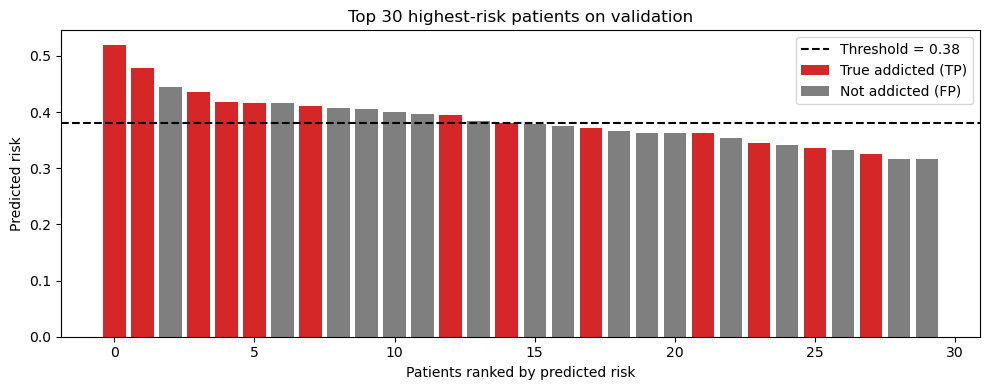

In [19]:
THR = res["threshold"] # <- use the threshold from the previous step
y_score_val = positive_scores(calibrated_clf, X_val)
ids = np.arange(len(y_val))

# Sort patients by predicted risk
order = np.argsort(-y_score_val)
top_idx = order[:30]   # top 30 for visualization
top_scores = y_score_val[top_idx]
top_true = np.asarray(y_val)[top_idx].astype(int)

# Split indices for TP vs FP
tp_idx = np.where(top_true == 1)[0]
fp_idx = np.where(top_true == 0)[0]

plt.figure(figsize=(10, 4))
plt.bar(tp_idx, top_scores[tp_idx], color="tab:red", label="True addicted (TP)")
plt.bar(fp_idx, top_scores[fp_idx], color="tab:gray", label="Not addicted (FP)")
plt.axhline(THR, linestyle="--", color="black", label=f"Threshold = {THR:.2f}")

plt.xlabel("Patients ranked by predicted risk")
plt.ylabel("Predicted risk")
plt.title("Top 30 highest-risk patients on validation")
plt.legend()
plt.tight_layout()
plt.show()

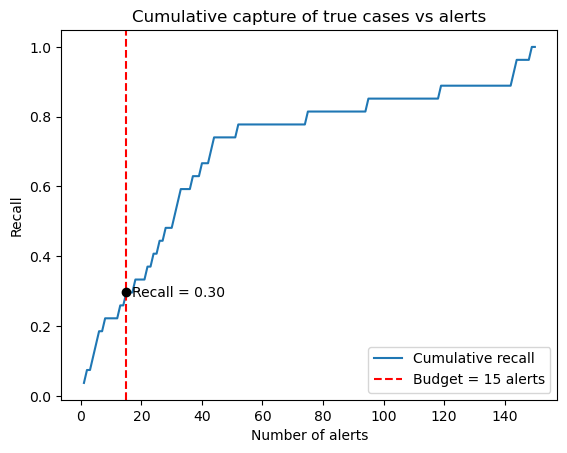

In [20]:
y_score_val = positive_scores(calibrated_clf, X_val)
order = np.argsort(-y_score_val)
y_sorted = np.asarray(y_val)[order].astype(int)

# Cumulative recall
cum_tp = np.cumsum(y_sorted)
total_pos = cum_tp[-1] if cum_tp.size else 0
alerts = np.arange(1, len(y_sorted) + 1)
recall_curve = cum_tp / total_pos if total_pos > 0 else np.zeros_like(cum_tp)

# Budget for alerts
n_budget = int(np.ceil(ALERTS_BUDGET * len(y_val) / 1000.0))

# Recall at budget
recall_at_budget = recall_curve[n_budget - 1] if n_budget > 0 and n_budget <= len(y_val) else 0.0

# Plot
plt.figure()
plt.plot(alerts, recall_curve, label="Cumulative recall")
plt.axvline(n_budget, linestyle="--", color="red", label=f"Budget = {n_budget} alerts")

# Annotate recall at budget
plt.scatter(n_budget, recall_at_budget, color="black", zorder=5)
plt.text(n_budget + 2, recall_at_budget, f"Recall = {recall_at_budget:.2f}", va="center")

plt.xlabel("Number of alerts")
plt.ylabel("Recall")
plt.title("Cumulative capture of true cases vs alerts")
plt.legend()
plt.show()

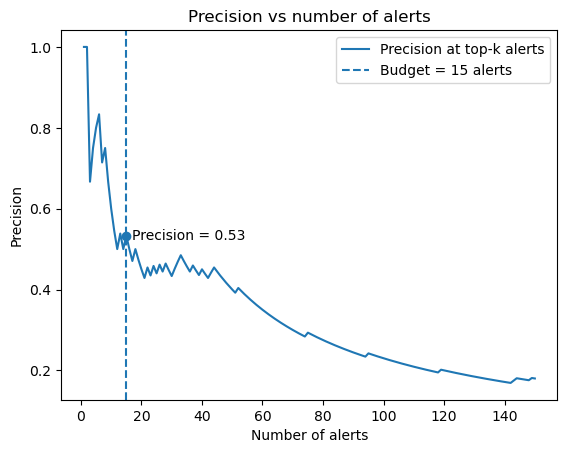

In [21]:
# Cumulative precision at top-k alerts
alerts = np.arange(1, len(y_sorted) + 1)
cum_tp = np.cumsum(y_sorted)
precision_curve = cum_tp / alerts

# Alerts budget scaled to validation size
prec_at_budget = precision_curve[n_budget - 1] if 0 < n_budget <= len(y_sorted) else 0.0

# Plot
plt.figure()
plt.plot(alerts, precision_curve, label="Precision at top-k alerts")
plt.axvline(n_budget, linestyle="--", label=f"Budget = {n_budget} alerts")
plt.scatter(n_budget, prec_at_budget, zorder=5)
plt.text(n_budget + max(2, len(y_sorted)//100), prec_at_budget, f"Precision = {prec_at_budget:.2f}", va="center")

plt.xlabel("Number of alerts")
plt.ylabel("Precision")
plt.title("Precision vs number of alerts")
plt.legend()
plt.show()


### 7.1.2. Recall floor then maximize precision for calibrated_clf on validation

- Recall floor: minimum acceptable recall set by safety policy to limit missed addiction cases
- Precision objective: among thresholds meeting the recall floor, pick the one with highest precision to reduce unnecessary undertreatment and clinician workload

Deciding which recall floor to sue:
1. The chosen floor is a value judgment balancing patient safety vs resource burden
2. In medicine, it's often the case that missing a true case (false negative) is often much worse than raising extra alarms (false positives)
3. A recall floor enforces a safety guarantee: the model must capture at least e.g. 60% of patients who will become addicted

Among thresholds that satisfy recall ≥ 0.6, you then pick the one with the best precision, to minimize unnecessary undertreatment and workload

threshold,0.28
metric,
precision,0.459
recall,0.630
TP,17.000
FP,20.000
TN,103.000
FN,10.000
alerts_per_1000,246.667
true_pos_per_1000,113.333


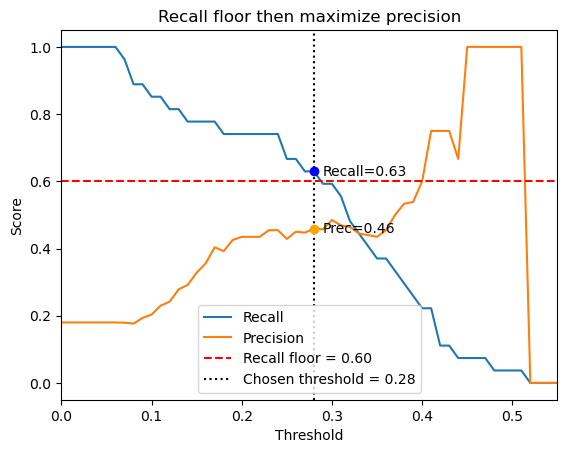

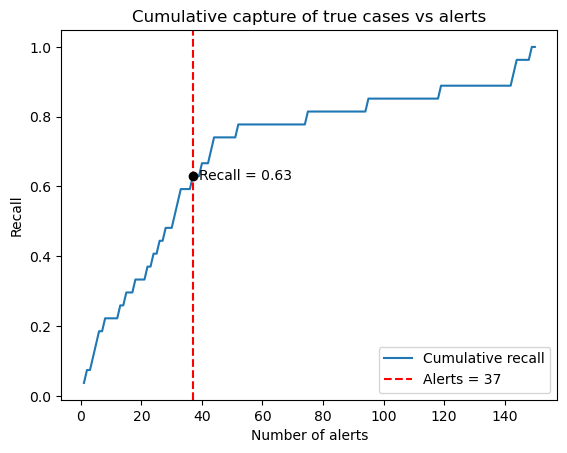

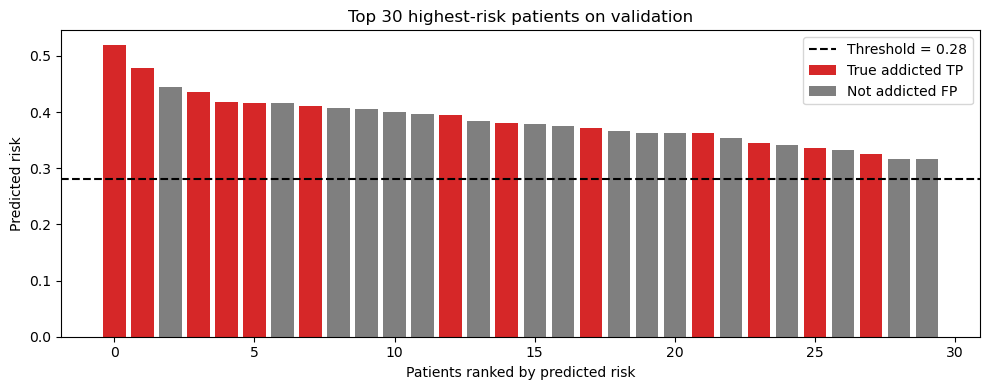

In [22]:
# Step 1: choose threshold by recall floor
RECALL_FLOOR = 0.60 # <- judgment call
y_score_val = positive_scores(calibrated_clf, X_val)
res = pick_threshold_recall_floor(y_val, y_score_val, recall_floor=RECALL_FLOOR)
THR = float(res["threshold"])

summary_df = summary_at_threshold(y_val, y_score_val, THR)
pivot_df = summary_df.set_index("threshold").T.reset_index().rename(columns={"index": "metric"})
display(pivot_df.round(3).set_index("metric"))

# Precision and recall vs threshold with annotations
plot_recall_floor_curves(y_val, y_score_val, recall_floor=RECALL_FLOOR, chosen_threshold=THR)

# Cumulative recall vs alerts with vertical line at alerts implied by THR
plot_cumulative_recall_at_threshold(y_val, y_score_val, chosen_threshold=THR)

# Patient-level prioritization view at THR
plot_topk_at_threshold(y_val, y_score_val, chosen_threshold=THR, top_k=30)

### 7.1.3. Cost based threshold for calibrated_clf on validation

This approach selects a threshold that minimizes the expected cost of errors. We need to estimate the relative costs of false negatives (Givin opioid drugs to people who would actually get addited) and false positives (Depriving low risk people from receiving the medicine, costs in other terapies, etc.).

- Cost of a False Negative (C_FN): The cost of missing a patient who will develop an opioid use disorder (e.g., costs of future intensive treatment, overdose events, and negative health outcomes, social impact, etc.)

- Cost of a False Positive (C_FP): The cost of incorrectly flagging a patient as high-risk (e.g., costs of unnecessary clinical review, potential undertreatment of legitimate pain, and patient anxiety)

For this exercise, we will assume a cost ratio where a FN is 10 times more costly than a false positive. The optimal threshold is then found by minimizing the total expected cost (C_FP * FP + C_FN * FN) on the validation set

rule,Bayes formula,Empirical min cost
metric,,
threshold,0.090,0.170
precision,0.194,0.404
recall,0.889,0.778
TP,24.000,21.000
FP,100.000,31.000
TN,23.000,92.000
FN,3.000,6.000
alerts_per_1000,826.667,346.667
true_pos_per_1000,160.000,140.000


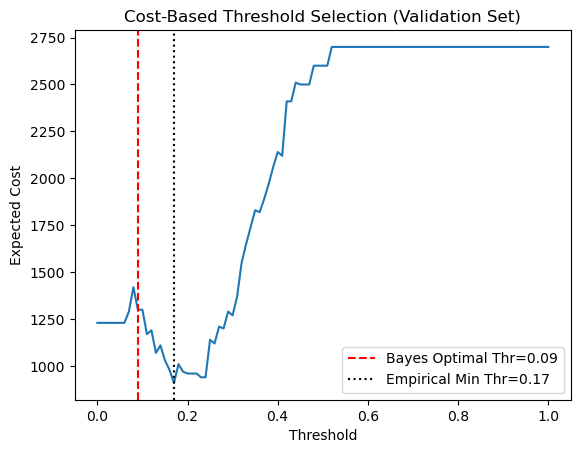

In [23]:
# Set domain costs
C_FN = 100.0  # Cost of a missed addiction case (False Negative)
C_FP = 10.0   # Cost of undertreated pain (False Positive)

# Get scores from the calibrated model on the validation set
y_score_val = positive_scores(calibrated_clf, X_val)

# Find the optimal thresholds based on cost
res = pick_threshold_cost(y_val, y_score_val, C_FP=C_FP, C_FN=C_FN)
tbl = res["table"].copy()
tbl["expected_cost"] = C_FP * tbl["FP"] + C_FN * tbl["FN"]

# Display a summary table comparing the two threshold options
summary_df = res["summary"] if isinstance(res["summary"], pd.DataFrame) else pd.DataFrame(res["summary"])

pivot_df = (
    summary_df.set_index("rule").T.reset_index().rename(columns={"index": "metric"})
)

display(pivot_df.round(3).set_index("metric"))

# Plot expected cost vs. threshold
plt.figure()
plt.plot(tbl["threshold"], tbl["expected_cost"])
plt.xlabel("Threshold")
plt.ylabel("Expected Cost")
plt.title("Cost-Based Threshold Selection (Validation Set)")

# Annotate the two optimal thresholds found
t_formula = res["threshold_formula"]
t_emp = res["threshold_empirical"]
plt.axvline(t_formula, linestyle="--", color="red", label=f"Bayes Optimal Thr={t_formula:.2f}")
plt.axvline(t_emp, linestyle=":", color="black", label=f"Empirical Min Thr={t_emp:.2f}")
plt.legend()
plt.show()


Visualizing performance at the empirical cost-based threshold of 0.170:


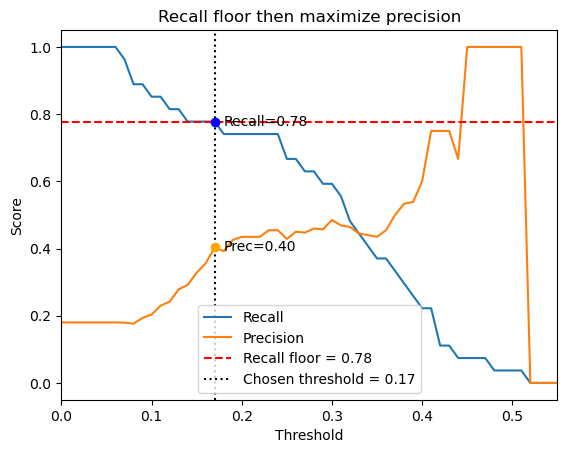

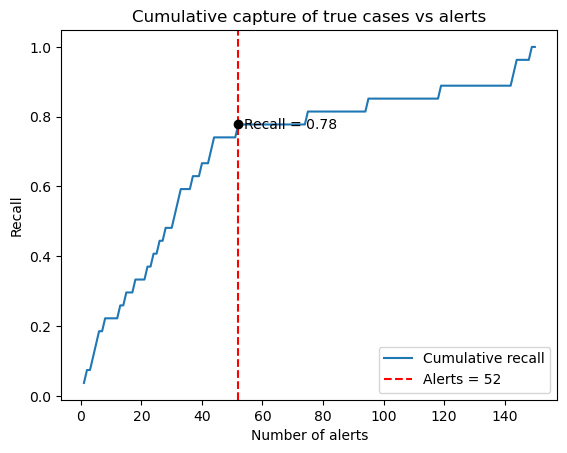

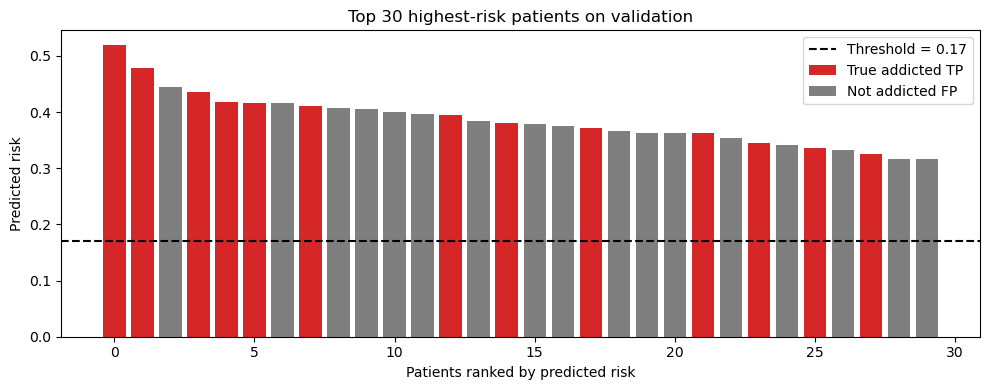

In [24]:
# Get the empirically optimal threshold from the previous analysis
THR = res["threshold_empirical"]

# For visualization, we need a "recall_floor" to draw the horizontal line.
# We'll use the actual recall achieved at our chosen cost-based threshold.
y_pred_val = (y_score_val >= THR).astype(int)
recall_at_thr = recall_score(y_val, y_pred_val)

print(f"Visualizing performance at the empirical cost-based threshold of {THR:.3f}:")
plot_recall_floor_curves(y_val, y_score_val, recall_floor=recall_at_thr, chosen_threshold=THR)
plot_cumulative_recall_at_threshold(y_val, y_score_val, chosen_threshold=THR)
plot_topk_at_threshold(y_val, y_score_val, chosen_threshold=THR, top_k=30)


# 8. Final Threshold Selection and Test Set Evaluation

This is a crucial step that often involves discussion with clinical stakeholders to align the model's operating point with clinical goals, patient safety requirements, and resource availability

| Thresholding Method | Objective | Pros (Best for...) | Cons (Potential Risks) |
| :--- | :--- | :--- | :--- |
| **1. Workload Constrained** | Maximize TP (addiction risk) under a fixed (alert) budget | Good for limited resources, ensuring Ops stability | A low budget will miss many high-risk patients |
| **2. Recall Floor** | Maximize precision (TP vs. FP) while holding a minimum recall rate (breath) | Acts as a safety net, ensuring a minimum capture rate | Increases false alarms e.g. workloads from alternative treatments, untreated pain |
| **3. Cost-Based** | Minimize total expected cost by assigning costs to errors | Provides a formal f/ work to balance different clinical errors | Highly dependent on accurate cost estimates (can be subjective) |

1. Compute the candidate threshold (THR) for each policy on the validation set
2. Compare them on consistent operational metrics and expected cost
3. Lock the final threshold using the same (THR) variable, to get an unbiased estimate

In [25]:
# Thresholds are derived on validation, comparison is on test

# Scores
y_score_val = positive_scores(calibrated_clf, X_val)
y_score_test = positive_scores(calibrated_clf, X_test)

# Derive thresholds on validation only, for the three methods
res_rec  = pick_threshold_recall_floor(y_val, y_score_val, recall_floor=RECALL_FLOOR)
thr_rec  = float(res_rec["threshold"])

res_work = pick_threshold_workload(y_val, y_score_val, alerts_per_1000_max=ALERTS_BUDGET)
thr_work = float(res_work["threshold"])

res_cost = pick_threshold_cost(y_val, y_score_val, C_FP=C_FP, C_FN=C_FN)
thr_cost_emp = float(res_cost["threshold_empirical"])

# Compare policies on the unseen test set using the frozen (validation) thresholds
rows = []
for approach, thr in [
    ("1. Workload budget", thr_work),
    ("2. Recall floor",    thr_rec),
    ("3. Cost min emp",    thr_cost_emp),
]:
    s = summary_at_threshold(y_test, y_score_test, thr).iloc[0].to_dict()
    s.update({
        "approach": approach,
        "expected_cost": float(C_FP * s["FP"] + C_FN * s["FN"]),
    })
    rows.append(s)

test_compare = (
    pd.DataFrame(rows)[
        ["approach", "threshold", "precision", "recall",
         "alerts_per_1000", "true_pos_per_1000", "TP", "FP", "FN", "expected_cost"]
    ]
    .sort_values("approach")
    .reset_index(drop=True)
)

pivot_df = (
    test_compare.set_index("approach").T.reset_index().rename(columns={"index": "metric"})
)

display(pivot_df.round(3).set_index("metric"))

# Also report threshold-independent curve metrics on test for context
test_roc_auc = float(roc_auc_score(y_test, y_score_test))
test_pr_auc  = float(average_precision_score(y_test, y_score_test))
print(f"Test ROC AUC={test_roc_auc:.3f}  |  Test PR AUC={test_pr_auc:.3f}")

approach,1. Workload budget,2. Recall floor,3. Cost min emp
metric,,,
threshold,0.380,0.280,0.170
precision,0.667,0.294,0.348
recall,0.222,0.556,0.889
alerts_per_1000,60.000,340.000,460.000
true_pos_per_1000,40.000,100.000,160.000
TP,2.000,5.000,8.000
FP,1.000,12.000,15.000
FN,7.000,4.000,1.000
expected_cost,710.000,520.000,250.000


Test ROC AUC=0.764  |  Test PR AUC=0.445


Based on this scenario:

- **Workload Constraint (THR = 0.38)**: Offers the highest precision (0.667) but the lowest recall (0.222), missing 7 of the 9 actual OD cases. This might be operationally efficient but carries a high patient risk i.e. low coverage for all patients

- **Recall Floor (THR = 0.28)**: Guarantees a minimum level of patient safety by capturing over half the cases (recall = 0.556), at the cost of more false positive alerts i.e. more patients without opioid treatment (alternative treatments $$$)

- **Cost-Based (THR = 0.17)**: Provides the highest recall (0.889) and lowest "expected cost" based on our 10:1 cost ratio. However, it generates the most alerts (460 per 1000 patients), which may not be operationally feasible

In [26]:
test_compare = test_compare.sort_values('approach').reset_index(drop=True)

# Extract stats for each approach from the DataFrame
workload_stats = test_compare.iloc[0]
recall_stats = test_compare.iloc[1]
cost_stats = test_compare.iloc[2]

# Calculate total positive cases in the test set
total_pos_test = workload_stats['TP'] + workload_stats['FN']

# Dynamic markdown with increased font size using HTML <div>
markdown_text = f"""
* **Workload Constraint (THR = {workload_stats['threshold']:.2f}):** Offers the highest precision ({workload_stats['precision']:.3f}) but the lowest recall ({workload_stats['recall']:.3f}), missing {workload_stats['FN']:.0f} of the {total_pos_test:.0f} actual OD cases. This might be operationally efficient but carries a high patient risk
* **Recall Floor (THR = {recall_stats['threshold']:.2f}):** Guarantees a minimum level of patient safety by capturing over half the cases (recall = {recall_stats['recall']:.3f}), at the cost of more false positive alerts
* **Cost-Based (THR = {cost_stats['threshold']:.2f}):** Provides the highest recall ({cost_stats['recall']:.3f}) and lowest "expected cost" based on our 10:1 cost ratio. However, it generates the most alerts ({cost_stats['alerts_per_1000']:.0f} per 1000 patients), which may not be operationally feasible
"""

display(Markdown(markdown_text))


* **Workload Constraint (THR = 0.38):** Offers the highest precision (0.667) but the lowest recall (0.222), missing 7 of the 9 actual OD cases. This might be operationally efficient but carries a high patient risk
* **Recall Floor (THR = 0.28):** Guarantees a minimum level of patient safety by capturing over half the cases (recall = 0.556), at the cost of more false positive alerts
* **Cost-Based (THR = 0.17):** Provides the highest recall (0.889) and lowest "expected cost" based on our 10:1 cost ratio. However, it generates the most alerts (460 per 1000 patients), which may not be operationally feasible


**Potential Decision:** For this clinical use case, patient safety is paramount. Missing a potential opioid use disorder case (a False Negative) has a significantly higher societal and health cost than a false alarm (a False Positive). Therefore, we will adopt the **2. Recall Floor threshold** of 0.28.

This choice ensures we identify a majority of at-risk patients (recall > 0.5) while maintaining a manageable number of alerts for clinical review

In [27]:
# --- Scores and validation-derived thresholds (from your original code) ---
y_score_val = positive_scores(calibrated_clf, X_val)
y_score_test = positive_scores(calibrated_clf, X_test)

res_rec  = pick_threshold_recall_floor(y_val, y_score_val, recall_floor=RECALL_FLOOR)
thr_rec  = float(res_rec["threshold"])

res_work = pick_threshold_workload(y_val, y_score_val, alerts_per_1000_max=ALERTS_BUDGET)
thr_work = float(res_work["threshold"])

res_cost = pick_threshold_cost(y_val, y_score_val, C_FP=C_FP, C_FN=C_FN)
thr_cost_emp = float(res_cost["threshold_empirical"])

# --- Find the F1-optimal threshold on the VALIDATION set ---
thresholds_f1 = np.linspace(0.01, 0.99, 100)
f1_scores_val = [f1_score(y_val, (y_score_val >= thr).astype(int)) for thr in thresholds_f1]
thr_f1_optimal = thresholds_f1[np.argmax(f1_scores_val)]


# --- Compare all policies on the TEST set, now including F1 score ---
rows = []
# Add the new F1-optimized approach to the list
approaches = [
    ("1. Workload budget", thr_work),
    ("2. Recall floor",    thr_rec),
    ("3. Cost min emp",    thr_cost_emp),
    ("4. F1 Optimized",    thr_f1_optimal)
]

for approach, thr in approaches:
    # Get the standard summary metrics on the test set
    s = summary_at_threshold(y_test, y_score_test, thr).iloc[0].to_dict()
    
    # Calculate the F1 score on the test set for this threshold
    y_pred_test = (y_score_test >= thr).astype(int)
    f1 = f1_score(y_test, y_pred_test)
    
    # Update the dictionary with all relevant info
    s.update({
        "approach": approach,
        "expected_cost": float(C_FP * s["FP"] + C_FN * s["FN"]),
        "F1 Score": f1
    })
    rows.append(s)

# Create the final comparison DataFrame, now including the "F1 Score" column
test_compare = (
    pd.DataFrame(rows)[
        ["approach", "threshold", "precision", "recall", "F1 Score",
         "alerts_per_1000", "true_pos_per_1000", "TP", "FP", "FN", "expected_cost"]
    ]
    .sort_values("approach")
    .reset_index(drop=True)
)

# Pivot the DataFrame for the final transposed view
pivot_df = (
    test_compare.set_index("approach").T.reset_index().rename(columns={"index": "metric"})
)

display(pivot_df.round(3).set_index("metric"))

# --- Original threshold-independent metrics ---
test_roc_auc = float(roc_auc_score(y_test, y_score_test))
test_pr_auc  = float(average_precision_score(y_test, y_score_test))
print(f"Test ROC AUC={test_roc_auc:.3f}  |  Test PR AUC={test_pr_auc:.3f}")

approach,1. Workload budget,2. Recall floor,3. Cost min emp,4. F1 Optimized
metric,,,,
threshold,0.380,0.280,0.170,0.238
precision,0.667,0.294,0.348,0.316
recall,0.222,0.556,0.889,0.667
F1 Score,0.333,0.385,0.500,0.429
alerts_per_1000,60.000,340.000,460.000,380.000
true_pos_per_1000,40.000,100.000,160.000,120.000
TP,2.000,5.000,8.000,6.000
FP,1.000,12.000,15.000,13.000
FN,7.000,4.000,1.000,3.000


Test ROC AUC=0.764  |  Test PR AUC=0.445


--- Visualizing Final Performance on Test Set at Threshold = 0.28 ---
\n1. Precision-Recall Curve with Final Threshold and Resulting Recall


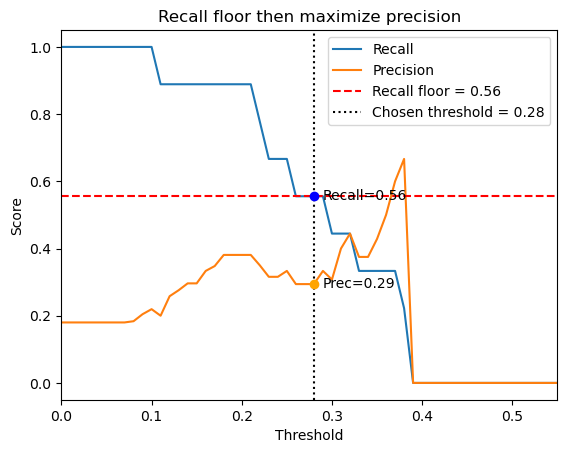

\n2. Cumulative Recall vs. Number of Alerts


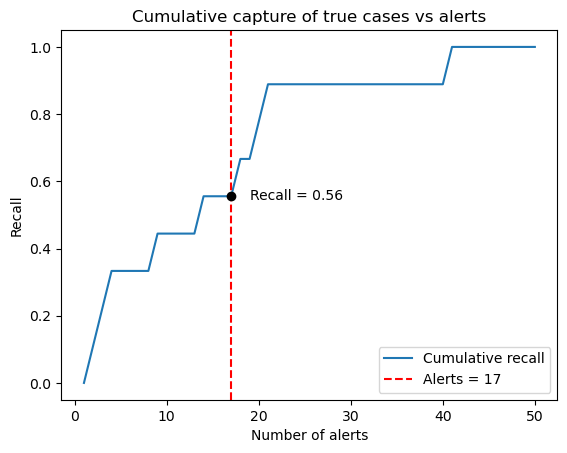

\n3. Top 30 Highest-Risk Patients View


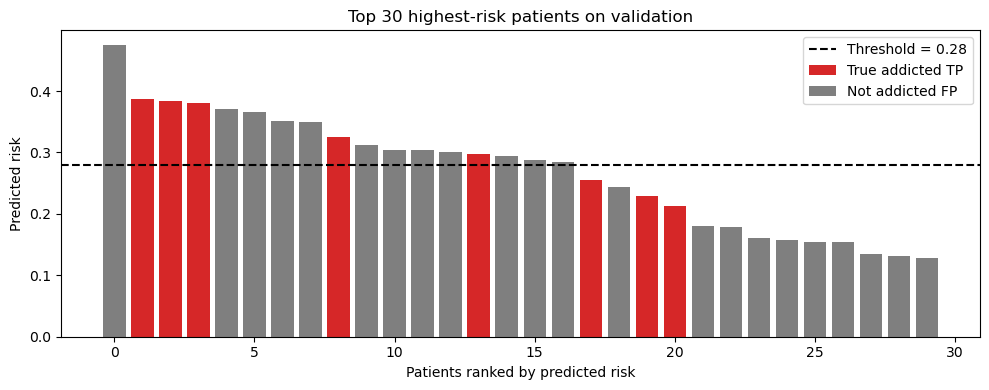

Final Calibrated Model on Test Set
PR AUC: 0.445
ROC AUC: 0.764
Prevalence p = 0.180  |  PR AUC lift = 2.47× over baseline


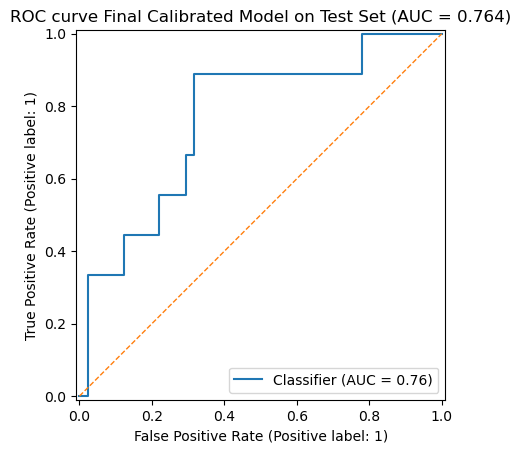

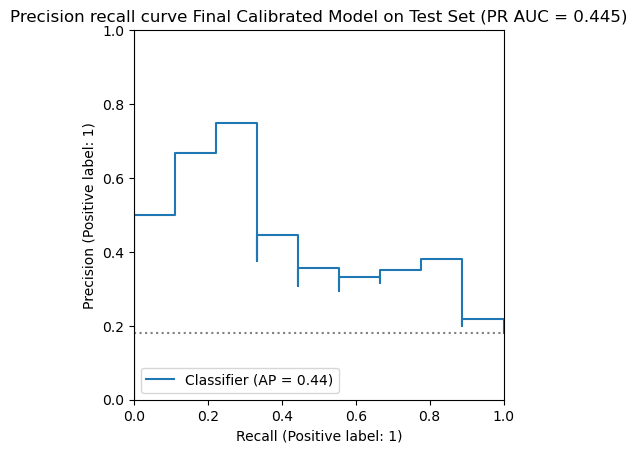

{'name': 'Final Calibrated Model on Test Set',
 'roc_auc': 0.7642276422764227,
 'pr_auc': 0.4446724308512926,
 'prevalence': 0.18,
 'lift': 2.470402393618292}

In [ ]:
# --- Final Threshold Selection (from your "Recall Floor" policy) ---
# This ensures THR is set to the value derived from the validation set analysis.
THR = thr_rec

print(f"--- Visualizing Final Performance on Test Set at Threshold = {THR:.2f} ---")

# --- Step 1: Get scores and metrics on the TEST set ---
y_score_test = positive_scores(calibrated_clf, X_test)

# For the first plot, we need the actual recall achieved on the test set by our threshold.
y_pred_test = (y_score_test >= THR).astype(int)
recall_at_thr_test = recall_score(y_test, y_pred_test)


# --- Step 2: Generate the plots sequentially using your utils functions ---

# Plot 1: Recall Floor Curves
print("\\n1. Precision-Recall Curve with Final Threshold and Resulting Recall")
plot_recall_floor_curves(y_true=y_test,
                         y_score=y_score_test,
                         recall_floor=recall_at_thr_test,
                         chosen_threshold=THR)

# Plot 2: Cumulative Recall vs. Alerts
print("\\n2. Cumulative Recall vs. Number of Alerts")
plot_cumulative_recall_at_threshold(y_true=y_test,
                                     y_score=y_score_test,
                                     chosen_threshold=THR)

# Plot 3: Top-k Patient Prioritization
print("\\n3. Top 30 Highest-Risk Patients View")
plot_topk_at_threshold(y_true=y_test,
                       y_score=y_score_test,
                       chosen_threshold=THR,
                       top_k=30)

# Generate the report and plots for the final model on the test set
auc_report(y_true=y_test,
           y_score=y_score_test,
           name="Final Calibrated Model on Test Set")

# 9. Intro to RAI toolkit
MS RAI Toolkit helps us inspecting our model beyond global metrics: it supports interpretability, fairness, error slice analysis, counterfactuals and causal probing 

- Our calibrated classifier makes predictions; RAI lets us explain how features drive those predictions in your data
- RAI surfaces groups (e.g. by “Low_inc”, “Surgery”) where model errors (false negatives/positives) may provide potential "biases" 
- It supports what-if and counterfactual analysis so we can test threshold policies more transparently

Steps:

1. Define train and test datasets + metadata (especially identity/sensitive features)
2. Create RAIInsights(...) with your model, data, target, task type
3. Add modules: explainer, error analysis, counterfactuals, causal analysis etc
4. Run .compute() then launch dashboard for visual & tabular inspection

## 9.1 Prepping RAI datasets and metadata

In [33]:
# 1) Resolve target name robustly
target_col = (
    target_col if "target_col" in globals() and isinstance(target_col, str)
    else (y_train.name if hasattr(y_train, "name") and y_train.name is not None else "OD")
)

# 2) Build train and test DataFrames including target
train_df_rai = X_train.copy()
train_df_rai[target_col] = pd.Series(y_train).values

test_df_rai = X_test.copy()
test_df_rai[target_col] = pd.Series(y_test).values

# 3) Resolve categorical-like binary features
if "cat_like_binary_cols" in globals() and isinstance(cat_like_binary_cols, (list, tuple)):
    cat_like_binary_cols = list(cat_like_binary_cols)
else:
    # Infer as columns with only {0,1} after dropping NaN
    def is_binary(col: pd.Series) -> bool:
        vals = pd.unique(col.dropna())
        return set(vals).issubset({0, 1})
    cat_like_binary_cols = [c for c in X_train.columns if is_binary(X_train[c])]

# 4) Identity feature for fairness slicing
identity_name = "Low_inc" if "Low_inc" in X_train.columns else None
feature_metadata = FeatureMetadata(
    identity_feature_name=identity_name,
    categorical_features=cat_like_binary_cols,
    dropped_features=[]
)

# 5) Classes for interpret dashboards
classes = sorted(pd.Series(y_train).dropna().unique().tolist())

# 6) Optional threshold wiring if available
# Adds calibrated score and decision using your selected threshold
if (
    "calibrated_clf" in globals()
    and callable(globals().get("positive_scores", None))
    and "thr_rec" in globals()
):
    THR = float(thr_rec)
    y_score_test = positive_scores(calibrated_clf, X_test)
    test_df_rai["score"] = y_score_test
    test_df_rai["pred_with_THR"] = (y_score_test >= THR).astype(int)

# Sanity echo
print(f"target_col: {target_col}")
print(f"identity_feature_name: {feature_metadata.identity_feature_name}")
print(f"categorical_features: {len(cat_like_binary_cols)} columns")
print(f"train_df_rai shape: {train_df_rai.shape}, test_df_rai shape: {test_df_rai.shape}")
if "THR" in globals():
    print(f"THR set to {THR:.4f}")


target_col: OD
identity_feature_name: Low_inc
categorical_features: 19 columns
train_df_rai shape: (800, 21), test_df_rai shape: (50, 23)
THR set to 0.2800


## 9.2 Build RAIInsights, add components, compute, and render

In [ ]:
# Ensure we pass identical feature columns (plus target) to RAIInsights
extra_cols = {"score", "pred_with_THR", "pred_before_cal", "raw_prob"}
required_cols = [c for c in train_df_rai.columns if c not in extra_cols]
if target_col not in required_cols:
    required_cols.append(target_col)

train_for_rai = train_df_rai[required_cols].copy()
test_for_rai = test_df_rai[required_cols].copy()

# Create RAIInsights using positional args to be version-safe
rai_insights = RAIInsights(
    calibrated_clf,       # model
    train_for_rai,        # train
    test_for_rai,         # test
    target_col,           # target column name
    task_type="classification",
    categorical_features=cat_like_binary_cols,
    feature_metadata=feature_metadata
)

# Add components
rai_insights.explainer.add()
rai_insights.error_analysis.add()
rai_insights.counterfactual.add(total_CFs=10, desired_class="opposite")
rai_insights.causal.add(treatment_features=["rx_ds", "Surgery"])

# Compute and persist
rai_insights.compute()
rai_insights.save("rai_od_dashboard")

# Launch dashboard
ResponsibleAIDashboard(rai_insights)


c:\Users\idiaz\miniconda3\envs\od_rai_lgbm\lib\site-packages\responsibleai\rai_insights\rai_insights.py:338: UserWarning: The categorical_features argument on the RAIInsights constructor is deprecated and will be removed after version 0.26. Please provide categorical features via the feature_metadata argument instead.
  warnings.warn("The categorical_features argument on the "


UserConfigValidationException: The features in train and test data do not match

# References

